# Normal Sun Mode 2016:324 analysis

### __Content__

1. __Star acquisition before entering the NSM__

1. __Determination of the true attitude and star identification__

1. __Attitude offset from the planned direction__

### __Summary__

* At the start of the 324:20:20z comm Chandra was observed to be in Normal Sun Mode. The OBC error-log dump indicated the NSM entry occurred at 12:59:32z, DOY 324.


* Shortly before the NSM entry, 7 stars were acquired (in all slots except slot 3). Kadi's <code>find_attitide</code> tool results in the following attitide solution:

<code>RA_true = 79.06 deg,
DEC_true = 34.30 deg,
ROLL_true = 122.00 deg.</code>

* The offset between the planned and true attitudes was <code>~171 arcsec</code>, or

<code>delta_roll = -50.08 arcsec,
delta_pitch = -127.38 arcsec,
delta_yaw = 113.89 arcsec.</code>


In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import Ska.engarchive.fetch as fetch
import Ska.quatutil as quatutil
from Ska.Matplotlib import plot_cxctime
from Chandra.Time import DateTime
from Quaternion import Quat
from kadi import events
import agasc
from chandra_aca.plot import plot_stars

### 1. Star acquisition before entering the NSM

In [2]:
# Approximate time range
tstart = '2016:324:12:56:30.000'
tstop = '2016:324:13:00:00.000'

In [3]:
msids = ["aoacfct{}".format(slot) for slot in range(8)]
dat = fetch.MSIDset(msids, start=tstart, stop=tstop)
slots = range(8)

In [4]:
snap_times = ['2016:324:12:56:58.200', '2016:324:12:57:01.275', '2016:324:12:57:06.400',
              '2016:324:12:57:19.725', '2016:324:12:59:42.200']

Time start = 2016:324:12:56, Time stop = 2016:324:13:00


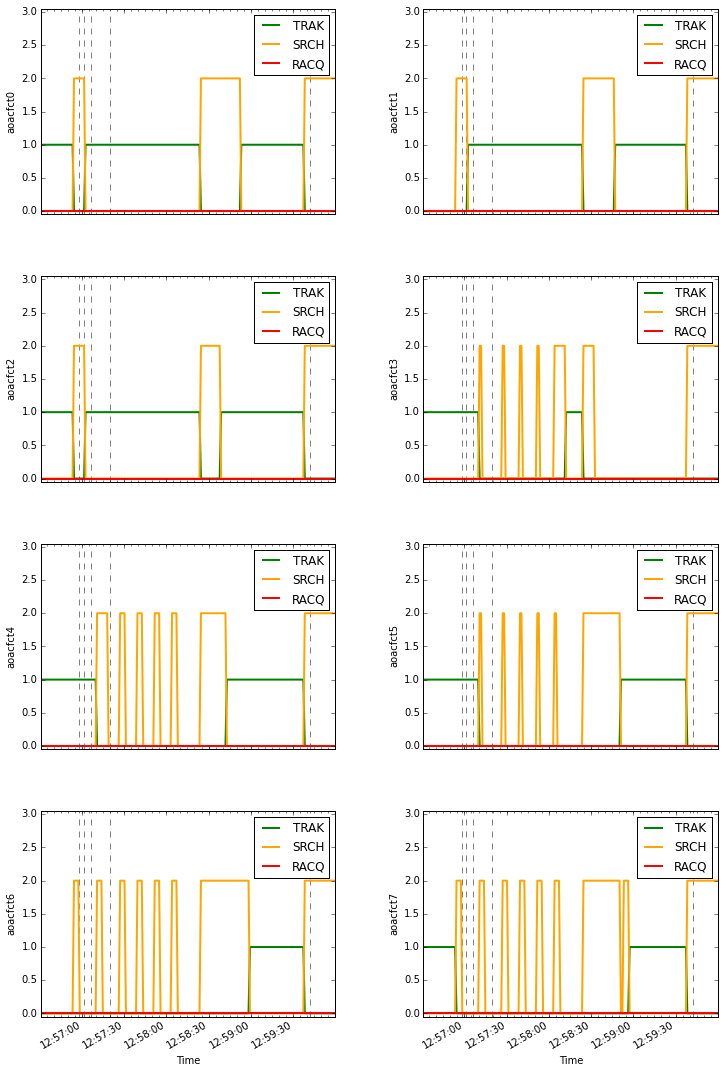

In [5]:
print 'Time start = {}, Time stop = {}'.format(tstart[:-7], tstop[:-7])

fig = plt.figure(figsize=(10, 20))

for slot in slots:
    trak = dat[msids[slot]].vals == 'TRAK'
    racq = dat[msids[slot]].vals == 'RACQ'
    srch = dat[msids[slot]].vals == 'SRCH'
    # Plot
    plt.subplot(4, 2, slot + 1)
    plot_cxctime(dat[msids[slot]].times, trak, color='green', lw=2, label='TRAK')
    plot_cxctime(dat[msids[slot]].times, srch * 2, color='orange', lw=2, label='SRCH')
    plot_cxctime(dat[msids[slot]].times, racq * 3, color='red', lw=2, label='RACQ')
    plt.ylim(-0.05, 3.05)
    plt.ylabel(msids[slot])
    plt.xlabel('Time')
    plt.vlines(DateTime(snap_times).plotdate, plt.ylim()[0], plt.ylim()[1],
               color='gray', linestyle='dashed')
    plt.legend()

plt.subplots_adjust(left=0.05, bottom=0.2, right=0.99, top=0.9, hspace=0.3, wspace=0.3)

__ Sequence of ACA snapshots __

The snapshot times correspond to the vertical lines in the <code>SRCH/TRAK</code> plots above.

* <code>12:56:57<code> -- stars were found in all slots except 1 and 6.

<img src='NSM_2016_324_12_56_58.png'>

* <code>12:57:01</code> -- stars only in slots 3, 4, 5

<img src='NSM_2016_324_12_57_01.png'>

* <code>12:57:06</code> -- FID lights in slots 0-2, three stars tracked in slots 3-5.

<img src='NSM_2016_324_12_57_06.png'>

* <code>12:57:19</code> -- lost stars in slots 3-5.

<img src='NSM_2016_324_12_57_19.png'>

* <code>12:58:30</code> -- no stars in any of the slots.

* Between <code>12:59:00</code> and <code>12:59:40</code> seven stars were tracked (all slots except of slot 3).

<img src='NSM_2016_324_12_59_42.png'>

### 2. Determination of the true attitude and star identification

* Find <code>(yag, zag, mag)</code> of the acquired stars.

* Use Kadi's <code>find_attitude</code> tool to find true <code>(RA, DEC, ROLL)</code>.

* Use <code>agasc</code> to identify the acquired stars.

In [6]:
keys = ['aoacmag', 'aoacyan', 'aoaczan']

In [7]:
def get_telem(slots, tstart, tstop):
    msids = []
    for slot in slots:
        for key in keys:
            msids.append(key + '{}'.format(slot))
    telem = fetch.MSIDset(msids, start=DateTime(tstart).date, stop=DateTime(tstop).date)
    return telem

In [8]:
# Approximate time of the star acquisition before the NSM
tstart = '2016:324:12:54:00.000'
tstop = '2016:324:13:00:00.000'

In [9]:
telem = get_telem(slots, tstart, tstop)

In [10]:
doy = '2016:324'

# Time ranges for which the mean values are computed, vertical dashed lines
slot_mean_times = {'start0': ['12:55:30', '12:59:00'], 'stop0': ['12:56:47', '12:59:35'],
                   'start1': ['12:57:06', '12:59:00'], 'stop1': ['12:58:20', '12:59:35'],
                   'start2': ['12:55:15', '12:59:00'], 'stop2': ['12:56:50', '12:59:35'],
                   'start3': ['12:55:17', '12:55:17'], 'stop3': ['12:57:07', '12:57:07'],
                   'start4': ['12:55:17', '12:59:00'], 'stop4': ['12:57:07', '12:59:35'],
                   'start5': ['12:55:30', '12:59:00'], 'stop5': ['12:57:07', '12:59:35'],
                   'start6': ['12:59:00', '12:59:00'], 'stop6': ['12:59:35', '12:59:35'],
                   'start7': ['12:54:57', '12:59:00'], 'stop7': ['12:56:50', '12:59:35']}

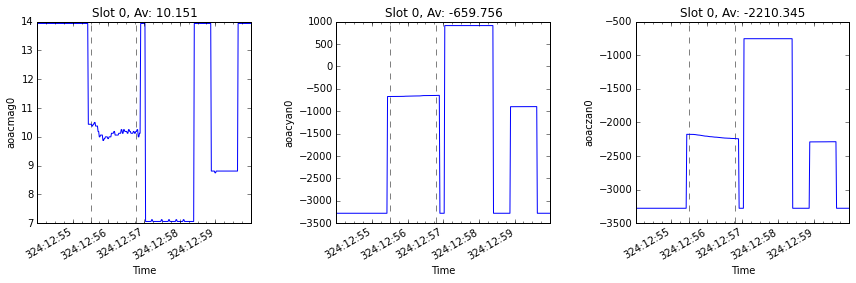

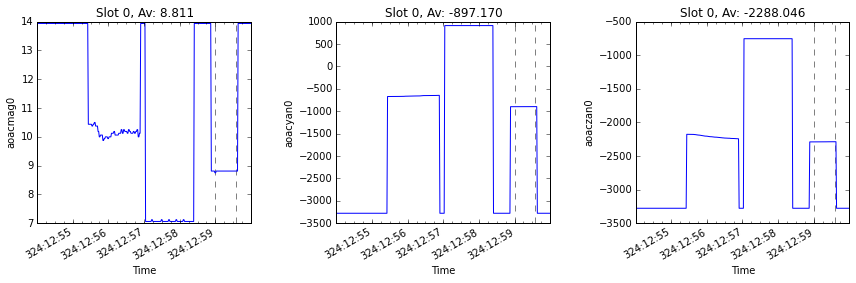

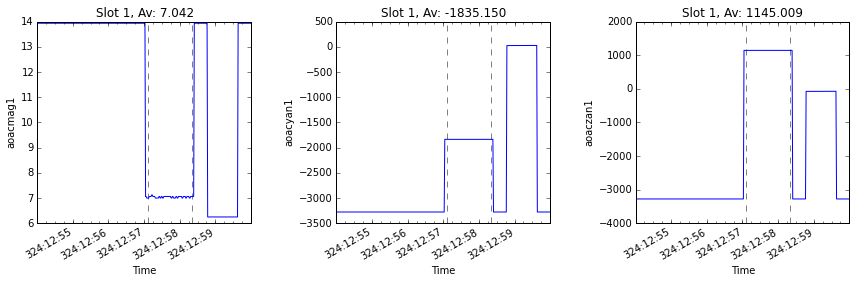

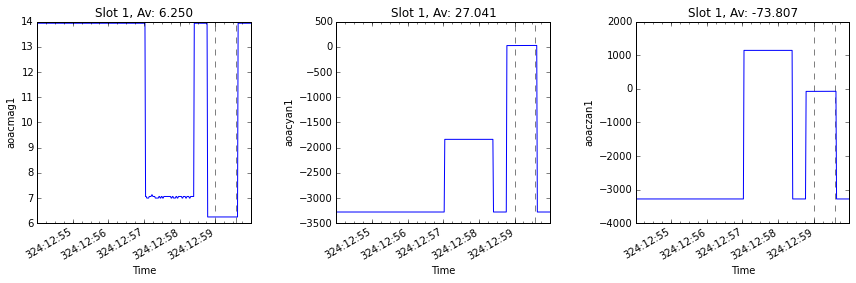

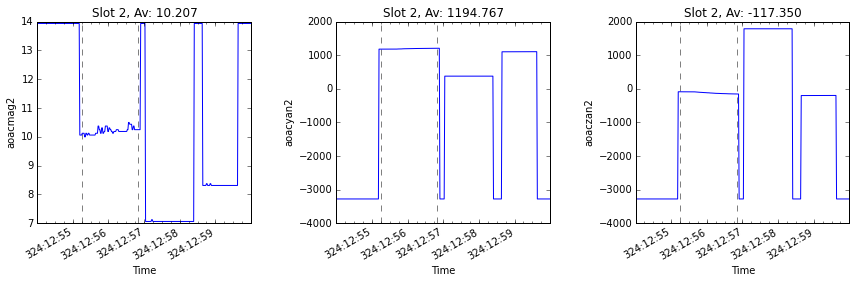

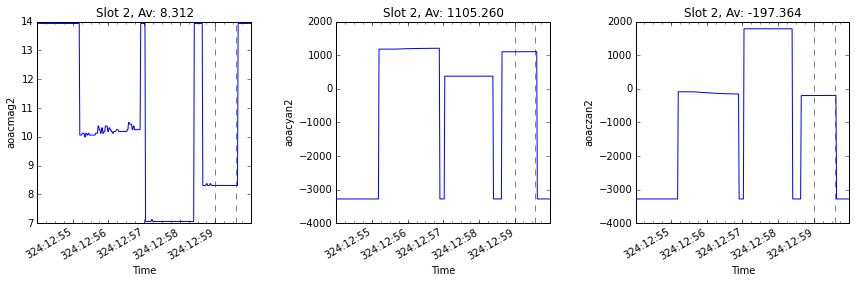

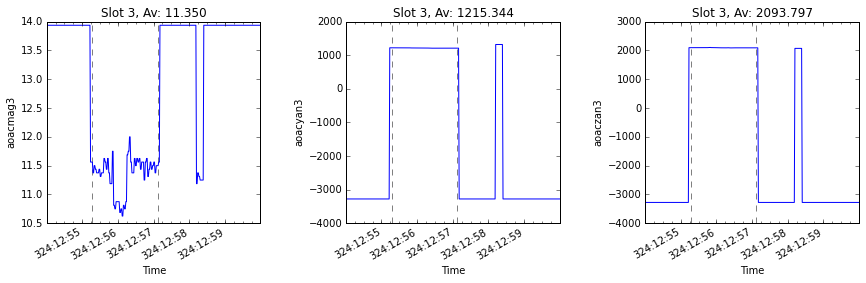

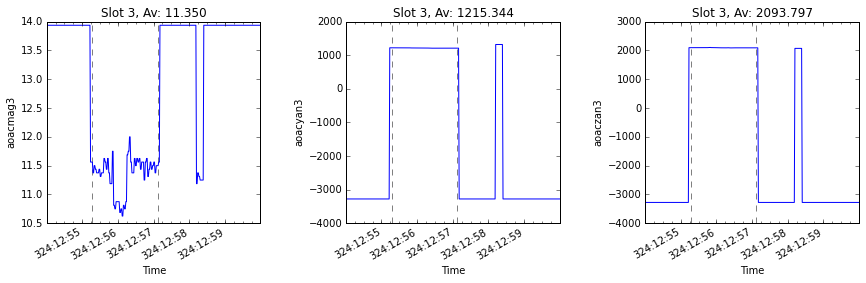

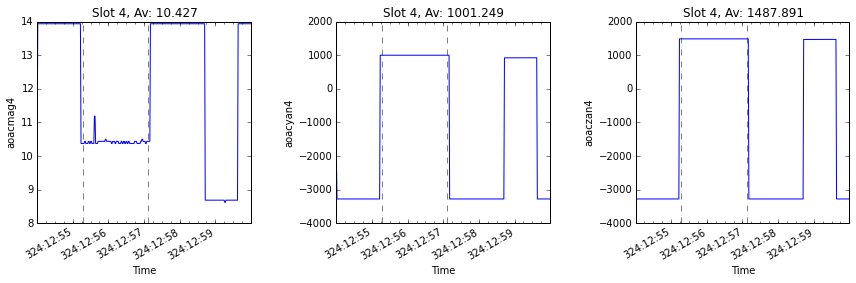

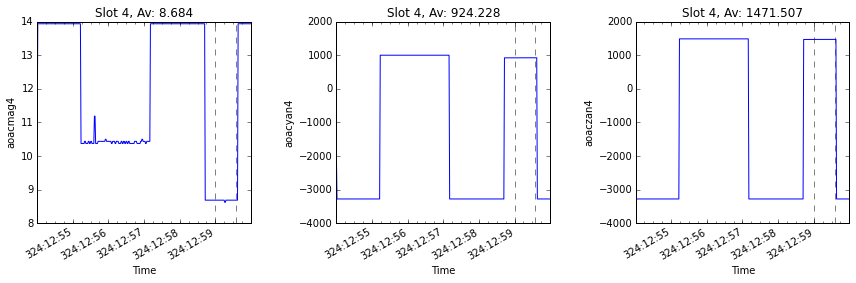

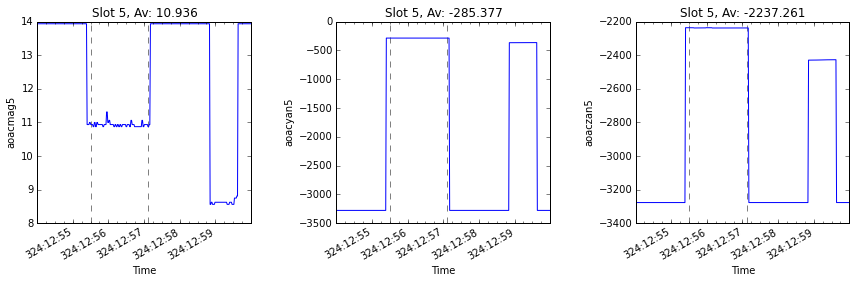

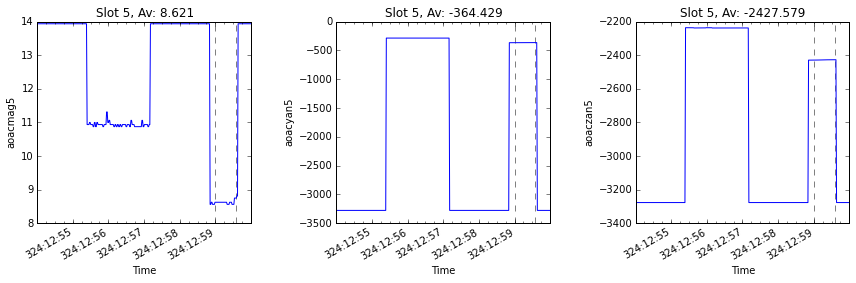

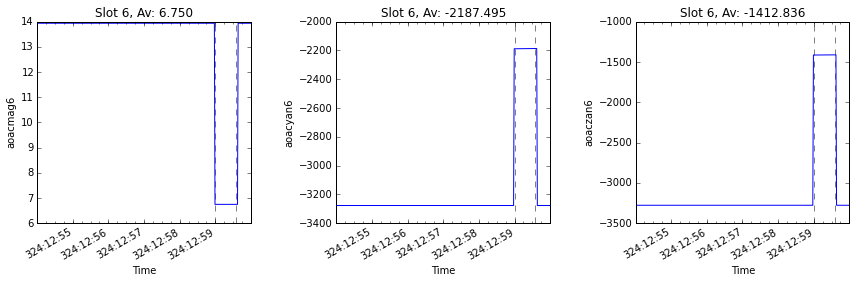

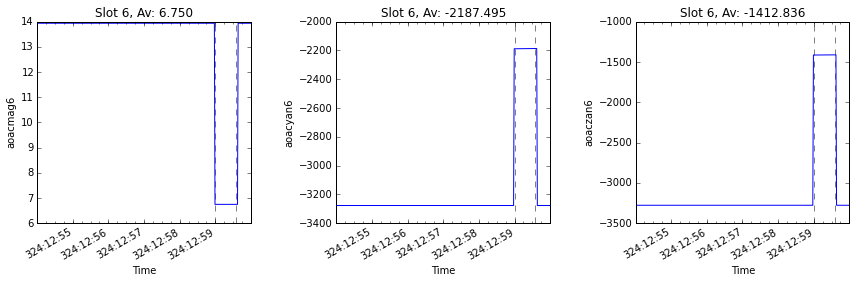

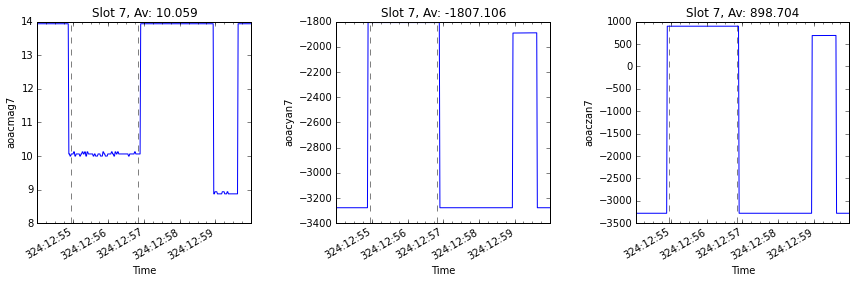

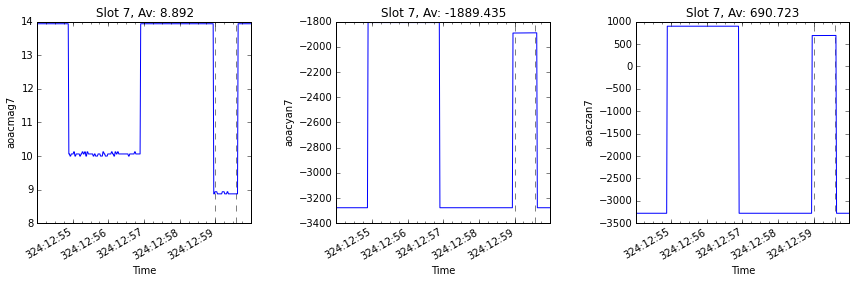

In [11]:
rows = []
for slot in slots:
    for tt in [0, 1]:
        row = {}
        start = '{}:{}.000'.format(doy, slot_mean_times['start{}'.format(slot)][tt])
        stop = '{}:{}.000'.format(doy, slot_mean_times['stop{}'.format(slot)][tt])
        plt.figure(figsize=(12, 4))
        for index, key in enumerate(keys):
            msid = key + '{}'.format(slot)
            times_mean = (telem[msid].times > DateTime(start).secs) & \
                         (telem[msid].times < DateTime(stop).secs)
            row['slot'] = slot
            average = telem[msid].vals[times_mean].mean()
            row[key] = average
            # Plot
            plt.subplot(1, 3, index + 1)
            plot_cxctime(telem[msid].times, telem[msid].vals)
            plt.ylabel(msid)
            plt.xlabel("Time")
            plt.title("Slot {0}, Av: {1:.3f}".format(slot, average))
            plt.vlines(DateTime([start, stop]).plotdate, plt.ylim()[0], plt.ylim()[1],
                       color='gray', linestyle='dashed')
        
        plt.subplots_adjust(left=0.05, bottom=0.2, right=0.99, top=0.9, wspace=0.4)
    
        rows.append(row)

__Determination of the true attitude__

In [12]:
t = Table(rows)
t['aoacyan'].format = '%.3f'
t['aoaczan'].format = '%.3f'
t['aoacmag'].format = '%.3f'

print t['slot', 'aoacyan', 'aoaczan', 'aoacmag' ]

slot  aoacyan   aoaczan  aoacmag
---- --------- --------- -------
   0  -659.756 -2210.345  10.151
   0  -897.170 -2288.046   8.811
   1 -1835.150  1145.009   7.042
   1    27.041   -73.807   6.250
   2  1194.767  -117.350  10.207
   2  1105.260  -197.364   8.312
   3  1215.344  2093.797  11.350
   3  1215.344  2093.797  11.350
   4  1001.249  1487.891  10.427
   4   924.228  1471.507   8.684
   5  -285.377 -2237.261  10.936
   5  -364.429 -2427.579   8.621
   6 -2187.495 -1412.836   6.750
   6 -2187.495 -1412.836   6.750
   7 -1807.106   898.704  10.059
   7 -1889.435   690.723   8.892


In [13]:
# Use http://kadi.cfa.harvard.edu/find_attitude/
#
# Take the second entry for each slot (except slot 3, ignore slot 3)
#
# Input:
#
#slot yag zag mag
#0 -897.169852941 -2288.04632353 8.81066
#1  27.0411764706 -73.8066176471    6.25
#2  1105.25955882 -197.363970588  8.3125
#4  924.227941176  1471.50661765 8.68382
#5 -364.429411765 -2427.57867647 8.62132
#6 -2187.49485294 -1412.83602941    6.75
#7 -1889.43455882  690.722794118 8.89154
#
# Output:
#
#Attitude solution
#
#RA=79.0593754872
#Dec=34.2952547304
#Roll=121.99536912
#
#Q1=0.735572563702
#Q2=0.421663082603
#Q3=0.493763651037
#Q4=0.193211555588
#
# Star match summary and residuals 
#
#slot      YAG            ZAG       MAG_ACA  m_yag     dy   m_zag     dz   dr  m_agasc_id
#---- -------------- -------------- ------- -------- ----- -------- ----- ---- ----------
#   0 -897.169852941 -2288.04632353 8.81066  -897.68  0.51 -2288.50  0.46 0.68  314322792
#   1  27.0411764706 -73.8066176471    6.25    27.17 -0.13   -73.85  0.05 0.14  314317808
#   2  1105.25955882 -197.363970588  8.3125  1105.52 -0.26  -197.33 -0.03 0.26  314313576
#   4  924.227941176  1471.50661765 8.68382   924.66 -0.43  1472.13 -0.62 0.75  314189096
#   5 -364.429411765 -2427.57867647 8.62132  -364.31 -0.12 -2427.70  0.12 0.17  314317160
#   6 -2187.49485294 -1412.83602941    6.75 -2187.51  0.01 -1413.03  0.20 0.20  314318832
#   7 -1889.43455882  690.722794118 8.89154 -1889.85  0.41   690.89 -0.17 0.45  313800960

# true attitude estimated based on the stars available before the NSM
RA_true = 79.0593754872
DEC_true = 34.2952547304
ROLL_true = 121.99536912
q_true = Quat((RA_true, DEC_true, ROLL_true))

__Identification of the acquired stars__

In [15]:
# ra, dec of the stars acquired before the NSM,
yag = (t['aoacyan'] * u.arcsec).to("deg").value
zag = (t['aoaczan'] * u.arcsec).to("deg").value
# using quat corresponding to the true attitute
ra, dec = quatutil.yagzag2radec(yag, zag, q_true)

# search radius
radius = (120. * u.arcsec).to('deg').value

cat_acquired = Table(names=('AGASC_ID', 'RA', 'DEC', 'MAG_ACA', 'DIST'),
                     dtype=('i9', 'f4', 'f4', 'f4', 'f4'))

for idx in range(8):
    for ii in [0, 1]:
        index = 2 * idx + ii
        cat = agasc.agasc.get_agasc_cone(ra=ra[index], dec=dec[index], radius=radius, date='2016:324')
        print 'Slot {}, magn = {:.3f}, yag = {:.0f}, zag = {:.0f}'.format(idx,
                                                                          t['aoacmag'][index],
                                                                          t['aoacyan'][index],
                                                                          t['aoaczan'][index],
                                                                          ra[index],
                                                                          dec[index])
        if len(cat)==0:
            print
            continue
        dists = []
        for cc in cat:
            dist = (agasc.agasc.sphere_dist(ra[index], dec[index],
                                            cc['RA'], cc['DEC']) * u.deg).to('arcsec')
            dists.append(dist.value)
        cat['DIST'] = dists
        cat['DIST'].format = '%.1f'
        cat['RA'].format = '%.2f'
        cat['DEC'].format = '%.2f'
        cat['MAG_ACA'].format = '%.3f'
        print cat['AGASC_ID', 'RA', 'DEC', 'MAG_ACA', 'DIST']
        print
        
        found = cat['DIST'] < 2.0
        acq = np.array(cat['AGASC_ID', 'RA', 'DEC', 'MAG_ACA', 'DIST'][found])
        if len(acq):
            cat_acquired.add_row(acq[0])

Slot 0, magn = 10.151, yag = -660, zag = -2210
 AGASC_ID   RA   DEC  MAG_ACA DIST
--------- ----- ----- ------- ----
314321072 79.82 34.47  10.445 47.5

Slot 0, magn = 8.811, yag = -897, zag = -2288
 AGASC_ID   RA   DEC  MAG_ACA  DIST
--------- ----- ----- ------- -----
314322792 79.87 34.42   9.048   0.7
314323424 79.84 34.43  11.445 102.3

Slot 1, magn = 7.042, yag = -1835, zag = 1145
 AGASC_ID   RA   DEC  MAG_ACA  DIST
--------- ----- ----- ------- -----
313802040 79.04 33.67  11.715  92.2
313800728 79.03 33.69  11.565 102.3
313800568 79.04 33.72  11.845 106.8

Slot 1, magn = 6.250, yag = 27, zag = -74
 AGASC_ID   RA   DEC  MAG_ACA DIST
--------- ----- ----- ------- ----
314317808 79.08 34.31   6.298  0.6

Slot 2, magn = 10.207, yag = 1195, zag = -117
 AGASC_ID   RA   DEC  MAG_ACA  DIST
--------- ----- ----- ------- -----
314313576 78.92 34.58   8.440 119.8
314317016 78.89 34.61   9.835  52.1
314313592 78.86 34.61  12.505  93.1

Slot 2, magn = 8.312, yag = 1105, zag = -197
 AGASC_ID

__Acquired stars__

In [16]:
cat_acquired['Slot'] = [0, 1, 2, 4, 5, 6, 6, 7]
cat_acquired['DIST'].format = '%.1f'
cat_acquired['RA'].format = '%.2f'
cat_acquired['DEC'].format = '%.2f'
cat_acquired['MAG_ACA'].format = '%.3f'
cat_acquired.remove_row(-2)

print cat_acquired

 AGASC_ID   RA   DEC  MAG_ACA DIST Slot
--------- ----- ----- ------- ---- ----
314322792 79.87 34.42   9.048  0.7    0
314317808 79.08 34.31   6.298  0.6    1
314313576 78.92 34.58   8.440  0.3    2
314189096 78.47 34.30   8.793  0.5    4
314317160 79.82 34.56   8.693  1.3    5
314318832 79.85 33.99   6.755  0.4    6
313800960 79.20 33.75   8.921  0.3    7


### 3. Attitude offset from the planned direction

In [17]:
#https://icxc.harvard.edu/mp/mplogs/2016/NOV1416/oflsa/starcheck.html#obsid19942
#OBSID: 19942  Ae Aur                 ACIS-I SIM Z offset:1920  (4.83mm) Grating: NONE 
#RA, Dec, Roll (deg):    79.115987    34.287170   121.977376
#Dither: ON  Y_amp= 8.0  Z_amp= 8.0  Y_period=1000.0  Z_period= 707.1
#  Q1,Q2,Q3,Q4: 0.73532705  0.42198566  0.49388627  0.19312839
#  MANVR: Angle=  95.01 deg  Duration= 1927 sec  Slew err= 59.5 arcsec
starcheck_catalog_dat = """
idx slot   id      type size   mag     maxmag yang   zang  sz what halfw
 1  0           1   FID  8x8   7.000   8.000    919   -744   1   1   25          
 2  1           5   FID  8x8   7.000   8.000  -1828   1153   1   1   25          
 3  2           6   FID  8x8   7.000   8.000    385   1797   1   1   25          
 4  3   314186320   BOT  6x6   9.048  10.547   1321   2055  13   1   85          
 5  4   314189096   BOT  6x6   8.793  10.297   1039   1599  20   1  120          
 6  5   314317160   BOT  6x6   8.693  10.203   -250  -2300  20   1  120          
 7  6   314318832   BOT  6x6   6.755   8.266  -2073  -1284  20   1  120
 8  7   314321208   GUI  6x6   7.923   9.594  -2095  -1203   1   1   25          
 9  7   313800960   ACQ  6x6   8.921  10.422  -1775    818  20   1  120          
10  0   314322792   ACQ  6x6   9.048  10.547   -784  -2160  20   1  120          
11  1   314317808   ACQ  6x6   6.298   7.797    141     53  20   1  120  
12  2   314313576   ACQ  6x6   8.440   9.938   1219    -70  20   1  120 
"""
starcheck_catalog = ascii.read(starcheck_catalog_dat)

# planned attitude
RA_plan = 79.115987
DEC_plan = 34.287170
ROLL_plan = 121.977376
q_plan = Quat((RA_plan, DEC_plan, ROLL_plan))

In [18]:
offset = (agasc.agasc.sphere_dist(RA_true, DEC_true, RA_plan, DEC_plan) * u.deg).to('arcsec')
print 'Offset: {0:.1f}'.format(offset)

Offset: 170.9 arcsec


In [19]:
dq = q_plan.dq(q_true)
print (dq.roll0 * 3600, dq.pitch * 3600, dq.yaw * 3600)

(-50.081543712826715, -127.38228683796987, 113.8941879330622)


__Planned attitude catalog plotted using planned quaternion__

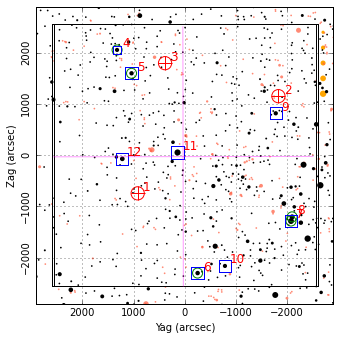

In [20]:
fig = plot_stars(q_plan, starcheck_catalog)

__Planned attitude catalog plotted using true quaternion__

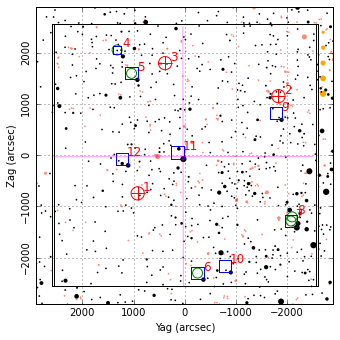

In [21]:
fig = plot_stars(q_true, starcheck_catalog)

Stars that were not acquired:

* <code>idx = 8</code> (GUI, <code>halfw = 25</code>),

* <code>idx = 4</code> (BOT, <code>halfw = 85</code>).